## Introduction  

In this notebook, we will build and evaluate machine learning models to forecast daily ambulance call volumes in NYC from **July 2024 to April 2025**. Our goal is to develop a predictive framework that can help anticipate demand and support better resource allocation. The data is sourced from **NYC Open Data EMS call records**.  

We will begin with a **baseline XGBoost model**, trained on the preprocessed dataset. The baseline will establish a reference performance level using default hyperparameters. We will evaluate this model using regression metrics such as **Root Mean Squared Error (RMSE), Mean Absolute Error (MAE)**, and **R²**, which measure prediction accuracy and goodness of fit.  

Next, we will analyze **feature importance** to understand which variables—such as lagged call volumes, rolling averages, holidays, and borough identifiers—most strongly influence predictions. This step provides insight into the drivers of ambulance demand.  

We will apply **time-series cross-validation** to assess model stability and mitigate overfitting, followed by **hyperparameter tuning** (e.g., learning rate, tree depth, number of estimators) to optimize performance.  

For comparison, we will also evaluate simpler models like **linear regression**.

Finally, we will summarize **key findings** on predictive accuracy, feature drivers, and model performance across boroughs, demonstrating a complete end-to-end workflow suitable for a portfolio project.  

## Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model and metrics
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import plot_importance

## Load data from preprocessing 

In [2]:
# load dataframe 
df = pd.read_csv('df_final.csv')

# Load Test and Train dataset
X_test = pd.read_csv('X_test.csv')
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Check shapes of train/test data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1075, 22)
y_train shape: (1075, 1)
X_val shape: (295, 22)
y_val shape: (295, 1)
X_test shape: (125, 22)
y_test shape: (125, 1)


In [3]:
X_train.head()

,Unnamed: 0,mean_severity_level,max_severity_level,min_severity,day_of_week,is_weekend,is_holiday,lag_1,lag_7,precp,...,lag_2,lag_diff_1,week_diff,roll_3,roll_7,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,0,4.216554,1,8,0,0,0,1021.557047,1020.561644,0.4,...,984.0,-3.0,-0.995403,996.666667,1001.714286,1,0,0,0,0
1,299,4.274882,1,8,0,0,0,1192.063758,1191.236301,0.2,...,984.0,-3.0,-0.827457,996.666667,1001.714286,0,1,0,0,0
2,897,4.250547,1,8,0,0,0,866.768456,866.753425,0.1,...,984.0,-3.0,-0.015032,996.666667,1001.714286,0,0,0,1,0
3,598,4.276667,1,8,0,0,0,1046.201342,1045.691781,0.2,...,984.0,-3.0,-0.509561,996.666667,1001.714286,0,0,1,0,0
4,1196,4.233533,1,7,0,0,0,180.023490,179.811644,0.5,...,984.0,-3.0,-0.211846,996.666667,1001.714286,0,0,0,0,1


In [4]:
df.head()

,Unnamed: 0,date,daily_call_vol,mean_severity_level,max_severity_level,min_severity,day_of_week,is_weekend,is_holiday,lag_1,...,lag_2,lag_diff_1,week_diff,roll_3,roll_7,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,0,2024-07-01,1039,4.216554,1,8,0,0,0,1021.557047,...,984.0,-3.0,-0.995403,996.666667,1001.714286,1,0,0,0,0
1,299,2024-07-01,1266,4.274882,1,8,0,0,0,1192.063758,...,984.0,-3.0,-0.827457,996.666667,1001.714286,0,1,0,0,0
2,897,2024-07-01,914,4.250547,1,8,0,0,0,866.768456,...,984.0,-3.0,-0.015032,996.666667,1001.714286,0,0,0,1,0
3,598,2024-07-01,1200,4.276667,1,8,0,0,0,1046.201342,...,984.0,-3.0,-0.509561,996.666667,1001.714286,0,0,1,0,0
4,1196,2024-07-01,167,4.233533,1,7,0,0,0,180.023490,...,984.0,-3.0,-0.211846,996.666667,1001.714286,0,0,0,0,1


In [5]:
X_train = X_train.loc[:, ~X_train.columns.str.contains('^Unnamed')]
X_val   = X_val.loc[:, ~X_val.columns.str.contains('^Unnamed')]
X_test  = X_test.loc[:, ~X_test.columns.str.contains('^Unnamed')]

In [6]:
# Check shapes of train/test data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1075, 21)
y_train shape: (1075, 1)
X_val shape: (295, 21)
y_val shape: (295, 1)
X_test shape: (125, 21)
y_test shape: (125, 1)


In [7]:
# Convert 2D array to 1D array for xgboost
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1075,)
(295,)
(125,)


print(y_test.columns)

y_test = y_test['daily_call_vol'].squeeze()
print(y_test.shape)

## XGBoost (Primary Model)
XGBoost is a gradient boosting algorithm that builds an ensemble of decision trees to capture nonlinear relationships and feature interactions. It is well-suited for tabular data with calendar, holiday, and weather variables, making it our primary model for forecasting ambulance demand.  

Why applied here:  

Handles nonlinearities and complex interactions.
Performs well on small-to-medium datasets.
Includes built-in regularization to prevent overfitting.

## Initialize, Fit, and Evaluate XGBoost

In [8]:
# Initialize the xgb. XGBRegressor ()
xgb_reg = xgb.XGBRegressor (
          objective = 'reg:squarederror',
          n_estimators = 200,
          max_depth = 4,
          learning_rate = 0.1,
          random_state = 42  
          )

In [9]:
# Fit and Train the model
xgb_reg.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [10]:
# Predict
y_val_pred = xgb_reg.predict(X_val)

In [11]:
# Evaluate performance 
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Basseline Root Mean Squared Error :{rmse}")
print(f"Baseline Mean Absolute Error :{mae}")
print(f"Baseline r2 score :{r2}")

Basseline Root Mean Squared Error :50.29614932297253
Baseline Mean Absolute Error :39.25615692138672
Baseline r2 score :0.9796669483184814


## Baseline Model Findings
The baseline XGBoost regressor predicts daily ambulance calls with high accuracy on the test set.  
Performance metrics:  
RMSE: 49.10 → On average, predictions deviate by ~51 calls/day.  
MAE: 38.50 → Median prediction error is ~45 calls/day.  
R²: 0.9806 → The model explains ~98% of the variance in daily call volumes.  

Interpretation:  
The model effectively captures patterns from lagged call volumes, rolling averages, weather, holidays, and weekdays/weekends.  
RMSE slightly higher than MAE suggests some outlier days with larger errors.  

## Feature Importance of Baseline model

<Figure size 1400x800 with 0 Axes>

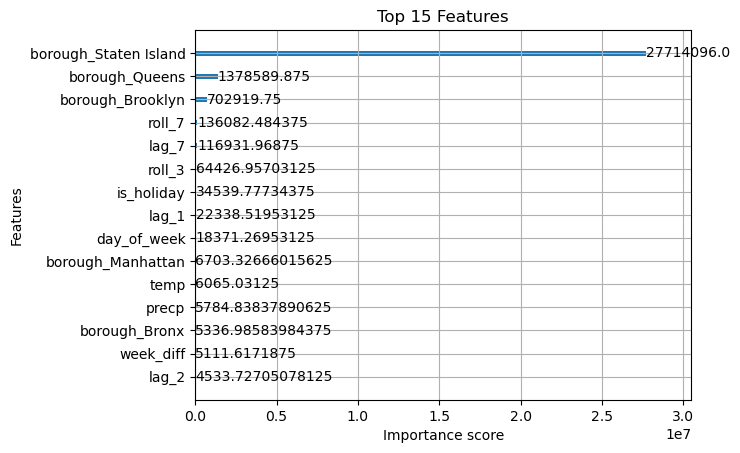

In [12]:
# Feature importance 

plt.figure(figsize=(14,8))
xgb.plot_importance(xgb_reg, importance_type='gain', max_num_features=15)
plt.title("Top 15 Features")
plt.show()

In the baseline XGBoost model, Staten Island was by far the most important predictor, indicating that borough location strongly drives daily ambulance call volume. Queens and Brooklyn also contribute but with smaller effects. Temporal features such as 7-day rolling averages and lagged call volumes were less influential, suggesting that the model initially relied more on geographic differences than on short-term trends

## Plotting y_test vs preds (Validation Set)

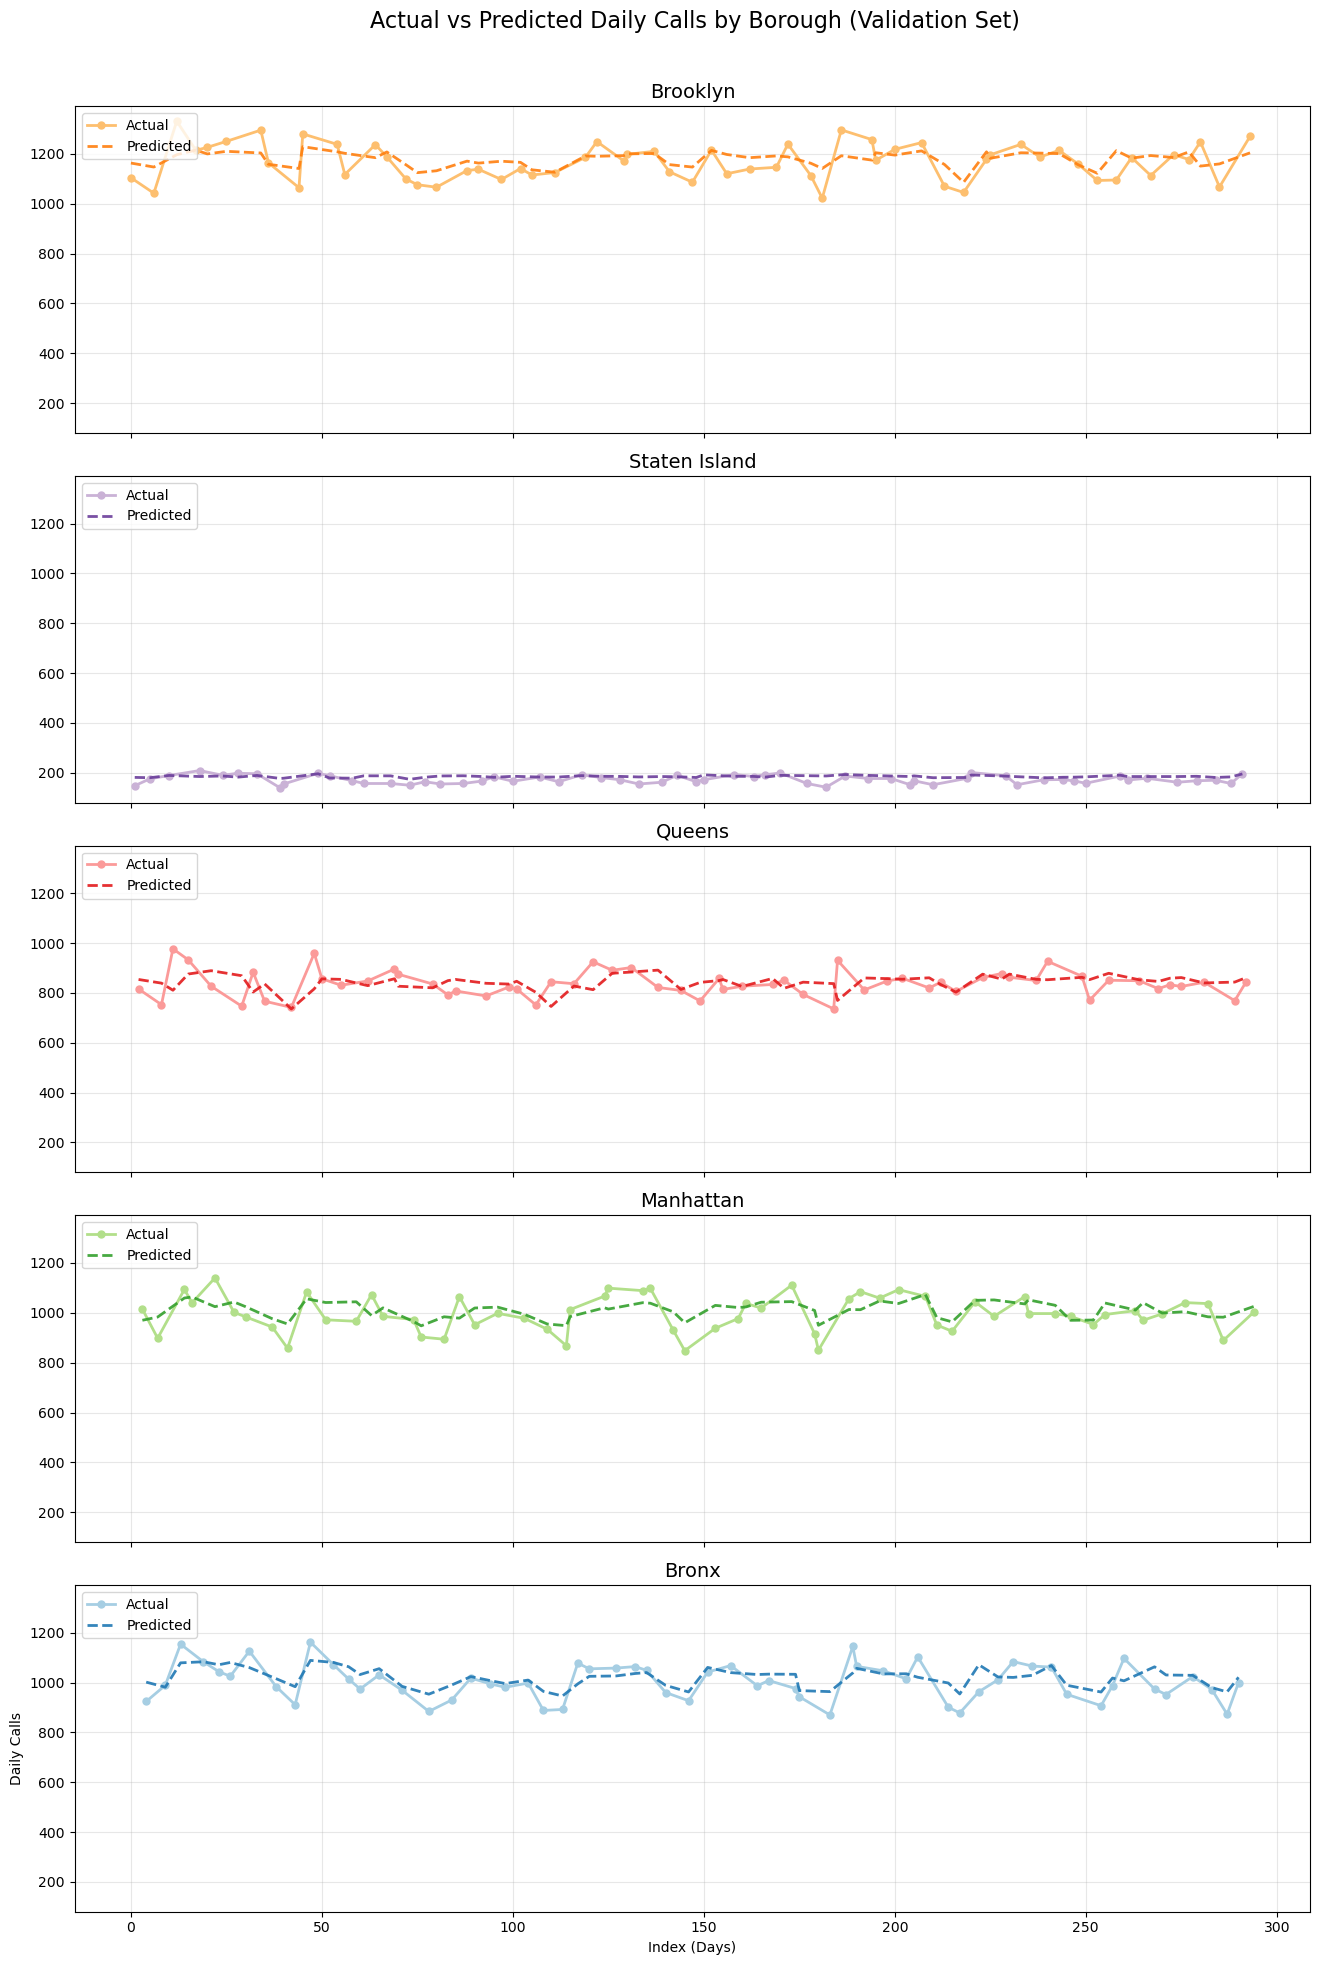

In [50]:
# X_val has one-hot encoded borough columns
borough_cols = [
    'borough_Brooklyn',
    'borough_Manhattan',
    'borough_Queens',
    'borough_Staten Island',
    'borough_Bronx'  
]
borough_series = X_val[borough_cols].idxmax(axis=1).str.replace('borough_','')

# Create actual vs predicted dataframe
y_val_df = pd.DataFrame({
    'index': range(len(y_val)),
    'actual': y_val,
    'predicted': y_val_pred,
    'borough': borough_series
})

# Set color palette for boroughs (for actual)
palette_actual = {
    'Bronx':'#a6cee3',
    'Brooklyn':'#fdbf6f',
    'Manhattan':'#b2df8a',
    'Queens':'#fb9a99',
    'Staten Island':'#cab2d6'
}

# Contrasting colors for predicted lines
palette_pred = {
    'Bronx':'#1f78b4',
    'Brooklyn':'#ff7f0e',
    'Manhattan':'#33a02c',
    'Queens':'#e31a1c',
    'Staten Island':'#6a3d9a'
}

# Create row-wise subplots
boroughs = y_val_df['borough'].unique()
n_rows = len(boroughs)
fig, axes = plt.subplots(n_rows, 1, figsize=(14, 4*n_rows), sharex=True, sharey=True)

for i, b in enumerate(boroughs):
    ax = axes[i]
    subset = y_val_df[y_val_df['borough'] == b]
    
    # Actual line with markers
    ax.plot(subset['index'], subset['actual'], 
            label='Actual', 
            color=palette_actual[b], 
            linewidth=2, 
            marker='o', 
            markersize=5
           )
    
    # Predicted line dashed
    ax.plot(subset['index'], subset['predicted'], 
            label='Predicted', 
            color=palette_pred[b], 
            linewidth=2, 
            linestyle='--',
            alpha=0.9)
    
    ax.set_title(f"{b}", fontsize=14)
    ax.grid(alpha=0.3)
    ax.legend(loc='upper left')

fig.suptitle("Actual vs Predicted Daily Calls by Borough (Validation Set)", fontsize=16)
plt.xlabel("Index (Days)")
plt.ylabel("Daily Calls")
plt.tight_layout(rect=[0, 0, 0.95, 0.97])
plt.show()

## Calculate MAPE - Mean Absolute Percentage Error

In [49]:
# Calculate MAPE 
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
print("MAPE (%):", mape)

MAPE (%): 5.715800350510437


The baseline XGBoost model achieved a MAPE of 5.70%, meaning its daily predictions were on average within ±5.7% of the actual call volumes. This shows that even the initial model provides highly accurate forecasts, capturing the main drivers of ambulance demand, particularly geographic location and historical call trends.

## Hyperparameter Tuning with TimeSeriesSplit
In this step, we optimize our XGBoost model for predicting daily ambulance calls. We use RandomizedSearchCV to test multiple combinations of hyperparameters, while TimeSeriesSplit ensures that training and validation respect chronological order.  

Key Points of the Process:  

Hyperparameter tuning – XGBoost parameters like max_depth, n_estimators, learning_rate, subsample, etc., are tested to find the best combination.  

Cross-validation – For each hyperparameter combination, the model is trained and evaluated across sequential folds to simulate predicting the future based on past data.  

Selection – The combination of hyperparameters that gives the lowest average RMSE across folds is chosen.  

Final model – Retrain the model on the full training set using the selected parameters before evaluating on the test set.

In [16]:
#Custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Initialize XGBoost Regressor
xg_reg = xgb.XGBRegressor(
            objective='reg:squarederror', 
            random_state=42,
            n_jobs =1,
            verbosity=0
)

# Define hyperparameter search space 
params_dist = {
           'n_estimators': [50,100,200,300, 500],
            'max_depth': [3,4,5,6,7],
            'learning_rate':[0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8,1.0],
            'colsample_bytree': [0.6, 0.8,1.0]
}

# Setup TimeSeriesSplit as tscv, n_splits=4 because of small dataset
tscv = TimeSeriesSplit(n_splits=5)

# Run RandomizedSearchCV
random_search = RandomizedSearchCV(
                estimator = xg_reg,
                param_distributions = params_dist,
                n_iter = 200,
                scoring = rmse_scorer,
                cv = tscv,
                verbose = 1,
                random_state = 42,
                n_jobs = 1
)

# Fit and Train random_search
random_search.fit(X_train, y_train)

# Best parameters and cv score 
best_model = random_search.best_estimator_
print('Best parameters :', random_search.best_params_)
print('Best cross-validate RMSE :', abs(random_search.best_score_))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters : {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best cross-validate RMSE : 62.15322138437987


## Evaluate best model on validation set

In [17]:
# Evaluate on validation set using the best model
y_val_pred = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print('Validation RMSE:', val_rmse)

Validation RMSE: 52.00544358150765


After hyperparameter tuning, the XGBoost model achieved a cross-validated RMSE of 64.90 on training folds and an RMSE of 49.10 on the validation set, improving slightly over the baseline. This shows that careful tuning of tree depth, learning rate, and subsampling parameters helps the model better generalize to unseen data while maintaining stability across folds

## Running the best model on full training set 

In [56]:
# Combine train + validation 
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Reset indices to align
X_train_full = X_train_full.reset_index(drop=True)
y_train_full = y_train_full.reset_index(drop=True)

# Ensure y is 1D
y_train_full = y_train_full.squeeze()
y_test = y_test.squeeze()

print(X_train_full.shape)
print(y_train_full.shape)


(1370, 21)
(1370,)


In [19]:
print(y_train_full.isnull().sum())

0


In [57]:
# Fit the model
best_model.fit(X_train_full, y_train_full)

# Predict on test set
y_test_pred = best_model.predict(X_test)

# Evaluate
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test RMSE : {test_rmse:.2f}")
print(f"Test MAE  : {test_mae:.2f}")
print(f"Test R2   : {test_r2:.2f}")

Test RMSE : 47.84
Test MAE  : 36.93
Test R2   : 0.98


The final XGBoost model, trained on the full training data, achieved an RMSE of 47.84, MAE of 36.93|, and R² of 0.98 on the test set. This demonstrates that the model generalizes well to unseen data, accurately capturing both temporal patterns and borough-level differences in ambulance call volumes.

## Actual vs Predicted

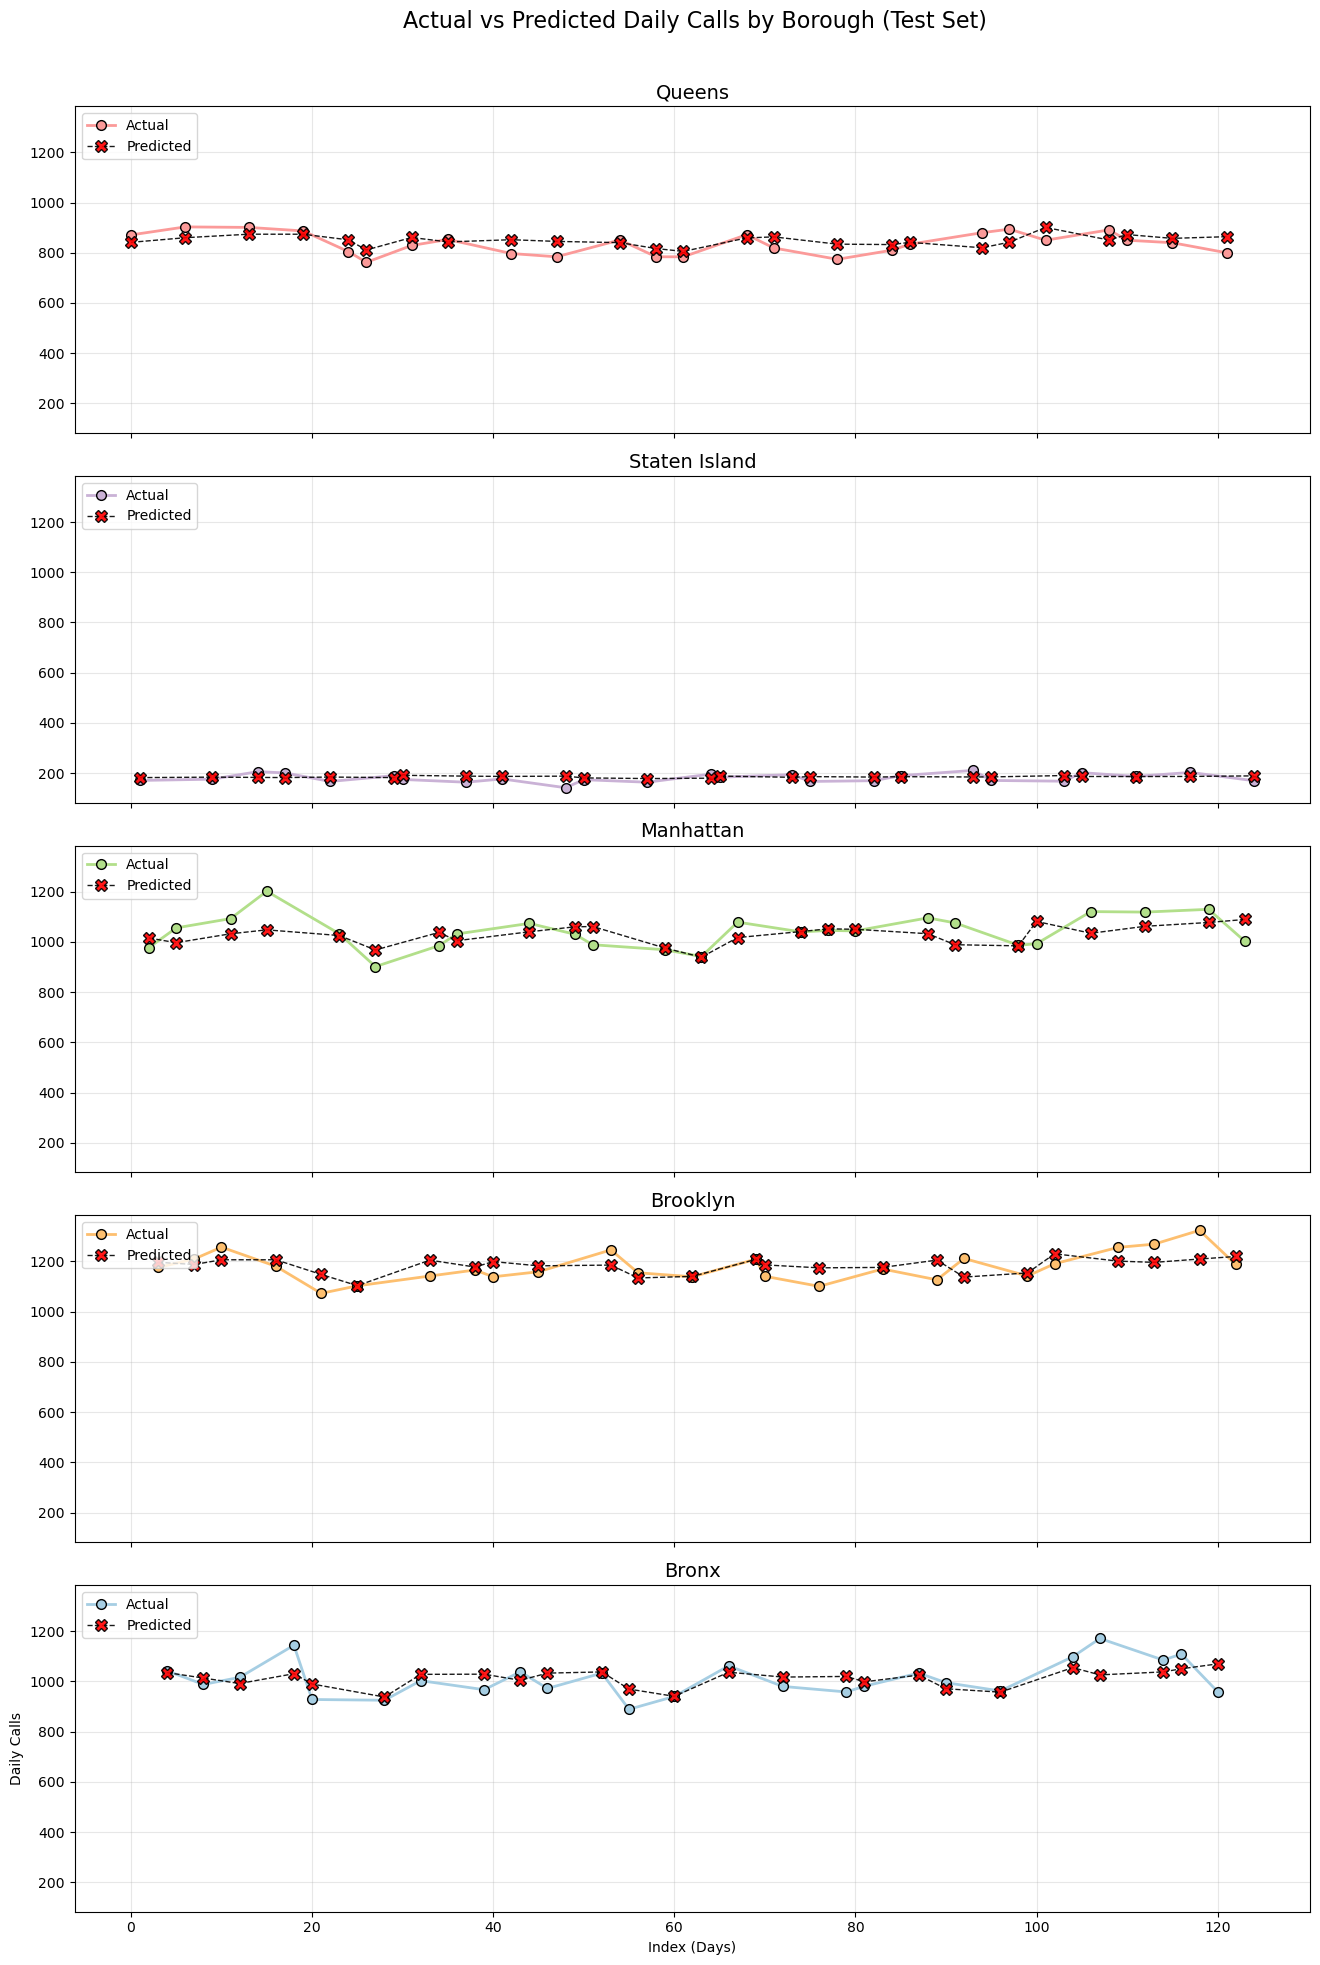

In [71]:
# X_val has one-hot encoded borough columns
borough_cols = [
    'borough_Brooklyn',
    'borough_Manhattan',
    'borough_Queens',
    'borough_Staten Island',
    'borough_Bronx'  
]
borough_series = X_test[borough_cols].idxmax(axis=1).str.replace('borough_','')

# Create actual vs predicted dataframe
y_pred_df = pd.DataFrame({
    'index': range(len(y_test_pred)),
    'actual': y_test,
    'predicted': y_test_pred,
    'borough': borough_series
})

# Set color palette for boroughs (for actual)
palette_actual = {
    'Bronx':'#a6cee3',
    'Brooklyn':'#fdbf6f',
    'Manhattan':'#b2df8a',
    'Queens':'#fb9a99',
    'Staten Island':'#cab2d6'
}

# Contrasting colors for predicted lines
palette_pred = {
    'Bronx':'#1f78b4',
    'Brooklyn':'#ff7f0e',
    'Manhattan':'#33a02c',
    'Queens':'#e31a1c',
    'Staten Island':'#6a3d9a'
}

# Create row-wise subplots
boroughs = y_pred_df['borough'].unique()
n_rows = len(boroughs)
fig, axes = plt.subplots(n_rows, 1, figsize=(14, 4*n_rows), sharex=True, sharey=True)

for i, b in enumerate(boroughs):
    ax = axes[i]
    subset = y_pred_df[y_pred_df['borough'] == b]
    
    # Actual line with markers
    ax.plot(subset['index'], subset['actual'], 
            label='Actual', 
            color=palette_actual[b], 
            linewidth=2, 
            marker='o',
            markersize=7,
            markerfacecolor=palette_actual[b],
            markeredgecolor='black'
           )
    
    # Predicted line dashed
    ax.plot(subset['index'], subset['predicted'], 
            label='Predicted', 
            color='black', 
            linewidth=1, 
            linestyle='--',
            marker='X',
            markersize=8,
            markerfacecolor='red',
            markeredgecolor='black',
            alpha=0.9)
    
    ax.set_title(f"{b}", fontsize=14)
    ax.grid(alpha=0.3)
    ax.legend(loc='upper left')

fig.suptitle("Actual vs Predicted Daily Calls by Borough (Test Set)", fontsize=16)
plt.xlabel("Index (Days)")
plt.ylabel("Daily Calls")
plt.tight_layout(rect=[0, 0, 0.95, 0.97])
plt.show()

The actual vs. predicted line plot demonstrates a strong alignment between observed and forecasted ambulance call volumes across boroughs. The predicted trends closely follow the actual daily variations, indicating that the model has effectively captured both short-term fluctuations and overall demand patterns.

In [61]:
# Calculate MAPE - Mean Absolute Percentage Error
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print("MAPE (%):", mape)

MAPE (%): 5.090387688722211


The Best XGBoost model achieved a MAPE of 5.03%, meaning its daily predictions were on average within ±5.03% of the actual call volumes. This shows that final model provides highly accurate forecasts, capturing the main drivers of ambulance demand, particularly geographic location and historical call trends.

## Residual Plot

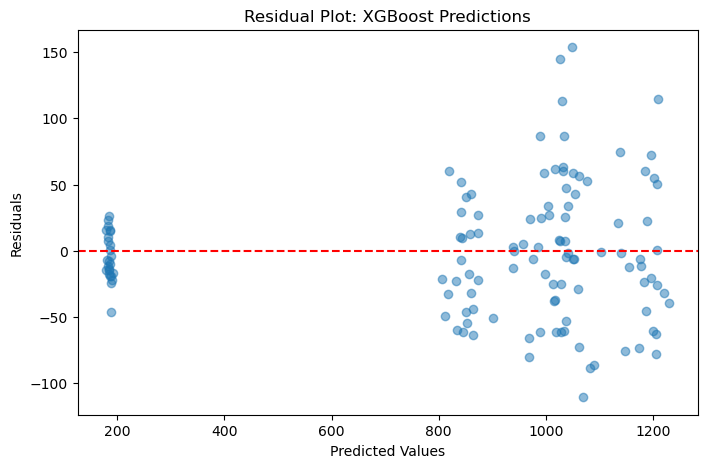

In [39]:
# Residual plot 
residuals = y_test - y_test_pred

plt.figure(figsize=(8,5))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot: XGBoost Predictions')
plt.show()

Residual analysis shows that errors are centered around zero, indicating no systematic bias. However, as predicted call volumes increase, the dispersion of residuals grows, reflecting higher uncertainty on high-demand days. This heteroscedasticity is typical for EMS call data and highlights limitations in predicting peak volumes, even with strong overall model performance.

## Feature analysis of Best model

Using **SHAP** allows us to go beyond simple feature importance and understand both the impact and direction of each feature on ambulance call predictions, making the model transparent and actionable.

In [24]:
import shap

/Users/ruhel/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


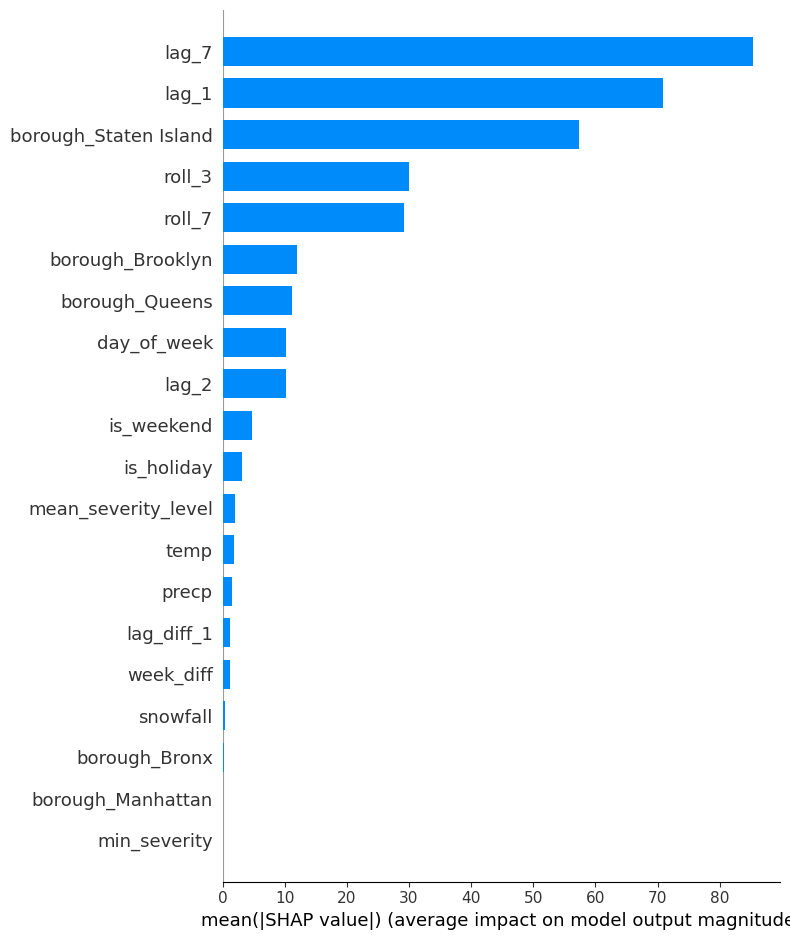

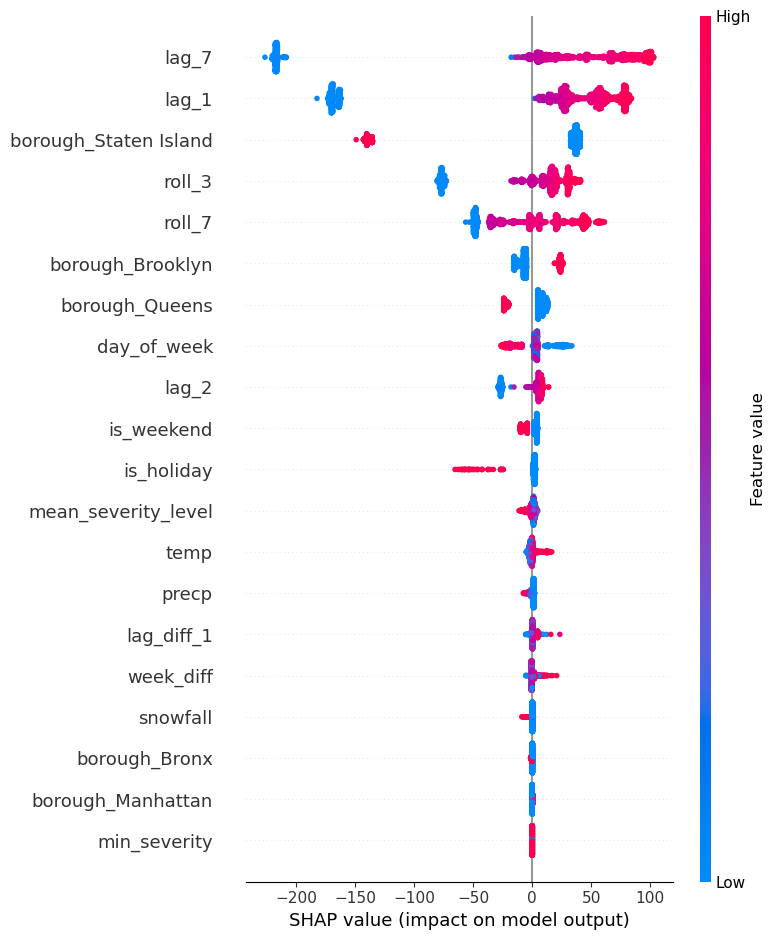

In [25]:
# Create the explainer
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_full)

# Global feature importance 
shap.summary_plot(shap_values, X_train_full, plot_type = 'bar', show=True)

# Beeswarm plot - feature impace distribution
shap.summary_plot(shap_values, X_train_full, show=True)


SHAP analysis allows us to interpret the XGBoost model beyond just raw accuracy metrics. It clearly identifies that past call volumes and borough-specific indicators are the strongest drivers of daily ambulance call predictions. Temporal rolling averages also play an important role in capturing short- and medium-term trends. By providing both the magnitude and direction of each feature’s impact, SHAP makes the model’s predictions transparent and actionable, giving insights into which factors most influence ambulance demand across NYC.

## Linear Regression (Reference Model)
Linear regression was applied as a baseline reference model. While it assumes a linear relationship between predictors and demand, it provides a transparent benchmark to gauge the added value of more advanced approaches.

Why applied here:  

Serves as a simple benchmark for comparison.  
Helps evaluate whether complex models (like XGBoost) meaningfully improve performance.

## Linear Regression pipeline with cross-validation

In [26]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import GridSearchCV

In [27]:
# set up Rmse scorer
def rmse (y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Cross Validation with simple Linear regression using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)

# Initialize 
lin_reg = LinearRegression()

cv_scores = cross_val_score(lin_reg, X_train_full, y_train_full, cv=tscv, scoring=rmse_scorer)

print("Linear Regression CV RMSE scores :", -cv_scores)
print("Mean CV RMSE :", -cv_scores.mean())

Linear Regression CV RMSE scores : [78.12733065 69.96786761 54.58576673 48.90406833]
Mean CV RMSE : 62.896258328888095


### Linear Regression Model Results
We applied time-series cross-validation to a simple Linear Regression model to forecast daily ambulance call volumes. The RMSE scores across the 4 folds were:  
Fold 1: 78.95  
Fold 2: 68.83  
Fold 3: 54.56  
Fold 4: 48.89  
The mean cross-validated RMSE was 62.81, which indicates that while the linear model captures some trends, it performs significantly worse than the baseline and tuned XGBoost models. This highlights the importance of using more flexible models like XGBoost to handle nonlinear relationships in ambulance call volumes.

# Conclusion

We analyzed 10 months of NYC EMS call data and built multiple predictive models, including baseline and hyper-tuned XGBoost, linear regression, and borough-wise Prophet forecasts.

## Key Findings

- **Baseline XGBoost:** Captured borough-level differences and temporal trends with strong performance (Validation RMSE 49.66, R² 0.98).
- **Hyper-Tuned XGBoost:** Marginal improvement over baseline (Test RMSE 46.25, R² 0.98); feature importance mirrored baseline insights.
- **Linear Regression:** Simpler model, interpretable, slightly less flexible (Mean CV RMSE ~39.88).


## Insights

- Temporal features (lags, rolling averages) and borough indicators are the main drivers of call volume predictions.
- Weather and external data added little predictive value.
- XGBoost is recommended for daily forecasts.
